<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Plot-line-graph" data-toc-modified-id="Plot-line-graph-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Plot line graph</a></span></li><li><span><a href="#Plot-treewidth-w/r-parameters" data-toc-modified-id="Plot-treewidth-w/r-parameters-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Plot treewidth w/r parameters</a></span></li><li><span><a href="#4-qubit-gates" data-toc-modified-id="4-qubit-gates-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>4-qubit gates</a></span></li></ul></div>

In [136]:
import qtree
import qensor
import qensor.optimisation as qopt
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import glob

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Text(0.5, 0, 'x')

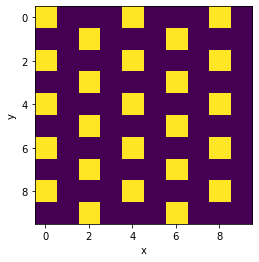

In [98]:
def shifted_tiling_gen(N):
    """ Generates indices on an NxN grid with non-adjacent tiles
    0123456
    #ooo#oo
    oo#ooo#
    #ooo#oo
    """
    rowa = range(0, N, 4)
    rowb = range(2, N, 4)
    rows = [rowa, rowb]*(N//2) + [rowa]*(N%2)
    indices = [list(zip([y]*len(x), x)) for y, x in enumerate(rows)]
    indices = sum(indices, [])
    return indices

N = 10
a = np.zeros((N, N))
indices = shifted_tiling_gen(N)
for ix in indices:
    a[ix] = 1
plt.imshow(a)
plt.ylabel('y')
plt.xlabel('x')

Text(0.5, 0, 'x')

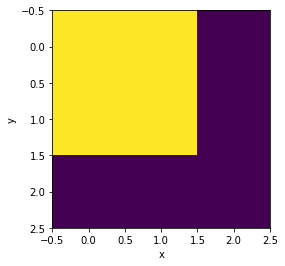

In [108]:
def lined_tiling_gen(N):
    """ Generates indices on an NxN grid with non-adjacent tiles
    0123456
    #o#o#
    ooooo
    #o#o#
    """
    rowa = range(0, N, 2)
    rows = [rowa]*((N+1)//2)
    indices = [list(zip([y*2]*len(x), x)) for y, x in enumerate(rows)]
    indices = sum(indices, [])
    return indices

N = 3
a = np.zeros((N, N))
indices = lined_tiling_gen(N)
for ix in indices:
    ix = ((ix[0]+1)%(N), (ix[1]+1)%(N) )
    a[ix] = 1
plt.imshow(a)
plt.ylabel('y')
plt.xlabel('x')


In [117]:
class ConstraintsComposer(qensor.CircuitComposer.CircuitComposer):
    def __init__(self, N, tiling_gen, *args, **kwargs):
        self.n_qubits = (N+1)**2
        super().__init__(self.n_qubits, *args, **kwargs)
        self.N = N
        self.tiling_gen = tiling_gen
    
    def apply_gate_ix(self, op, *indices, **args):
        qubits = [self.qubits[ix] for ix in indices]
        self.apply_gate(op, *qubits, **args)
    
    def _couple_gate(self, ix):
        side_len = self.N + 1
        self.apply_gate_ix(self.operators.cZ, ix, ix+1)
        self.apply_gate_ix(self.operators.cZ, ix+side_len, ix+side_len + 1)
        self.apply_gate_ix(self.operators.cZ, ix, ix+side_len)
        
    def get_circ(self, d):
        for i in range(d//2):
            self.layer_of_Hadamards()
            for ix in self.tiling_gen(self.N):
                self._couple_gate(ix[0]*(self.N+1) + ix[1])
                
            self.layer_of_Hadamards()
            for ix in self.tiling_gen(self.N):
                ix = ((ix[0]+1)%(self.N + 1), (ix[1]+1)%(self.N + 1) )
                if any(i>=self.N for i in ix):
                    continue
                       
                self._couple_gate(ix[0]*(self.N+1) + ix[1])
        if d%2:
            self.layer_of_Hadamards()
            for ix in self.tiling_gen(self.N):
                self._couple_gate(ix[0]*(self.N+1) + ix[1])
                
        return self.circuit
        
class QtreeConstraintsComposer(ConstraintsComposer,
                               qensor.QtreeCreator):
    pass

class CirqConstraintsComposer(ConstraintsComposer, qensor.CirqCreator):
    pass


In [118]:
composer = CirqConstraintsComposer(3, lined_tiling_gen)
qc = composer.get_circ(2)

print(qc)


               ┌───┐
0: ────H───@────@──────H───────────
           │    │
1: ────H───@────┼H─────────────────
                │
2: ────H───@────┼@─────H───────────
           │    ││
3: ────H───@────┼┼H────────────────
                ││
4: ────H───@────@┼─────H───────────
           │     │
5: ────H───@────H┼─────────@───@───
                 │         │   │
6: ────H───@─────@─────H───@───┼───
           │                   │
7: ────H───@────H──────────────┼───
                               │
8: ────H───@────@──────H───────┼───
           │    │              │
9: ────H───@────┼H─────────@───@───
                │          │
10: ───H───@────┼@─────H───@───────
           │    ││
11: ───H───@────┼┼H────────────────
                ││
12: ───H───@────@┼─────H───────────
           │     │
13: ───H───@────H┼─────────────────
                 │
14: ───H───@─────@─────H───────────
           │
15: ───H───@────H──────────────────
               └───┘


## Plot line graph

2020-07-24 00:33:05.827 | INFO     | qensor.optimisation.TensorNet:get_line_graph:49 - Line graph nodes: 360, edges: 579


Connectivity subgraph count: 7

[H(0), H(1), H(2), H(3), H(4), H(5), H(6), H(7), H(8), H(9), H(10), H(11), H(12), H(13), H(14), H(15), H(16), H(17), H(18), H(19), H(20), H(21), H(22), H(23), H(24), H(25), H(26), H(27), H(28), H(29), H(30), H(31), H(32), H(33), H(34), H(35), cZ(0,1), cZ(6,7), cZ(0,6), cZ(2,3), cZ(8,9), cZ(2,8), cZ(4,5), cZ(10,11), cZ(4,10), cZ(12,13), cZ(18,19), cZ(12,18), cZ(14,15), cZ(20,21), cZ(14,20), cZ(16,17), cZ(22,23), cZ(16,22), cZ(24,25), cZ(30,31), cZ(24,30), cZ(26,27), cZ(32,33), cZ(26,32), cZ(28,29), cZ(34,35), cZ(28,34), H(0), H(1), H(2), H(3), H(4), H(5), H(6), H(7), H(8), H(9), H(10), H(11), H(12), H(13), H(14), H(15), H(16), H(17), H(18), H(19), H(20), H(21), H(22), H(23), H(24), H(25), H(26), H(27), H(28), H(29), H(30), H(31), H(32), H(33), H(34), H(35), cZ(7,8)]


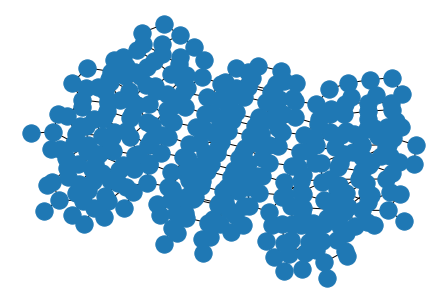

In [119]:
composer = QtreeConstraintsComposer(5, shifted_tiling_gen)
composer = QtreeConstraintsComposer(5, lined_tiling_gen)
qc = composer.get_circ(9)
tn = qopt.TensorNet.QtreeTensorNet.from_qtree_gates(qc)
nx.draw_kamada_kawai(tn.get_line_graph())
print('Connectivity subgraph count:', len(list(nx.connected_components(G))))
print()
print(qc[:100])

In [181]:

class FsimQtreeConstraints(QtreeConstraintsComposer):
    
    def _couple_gate(self, ix):
        side_len = self.N + 1
        op = self.operators.fSim
        self.apply_gate_ix(op, ix, ix+1, alpha=1, beta=1)
        self.apply_gate_ix(op, ix+side_len, ix+side_len + 1, alpha=1, beta=1)
        self.apply_gate_ix(op, ix, ix+side_len, alpha=1, beta=1)

## Plot treewidth w/r parameters

In [182]:
from itertools import product


def iter_params(params):
    keys = params.keys()
    for pvals in product(*params.values()):
        yield {k:v for k, v in zip(keys, pvals)}
    

def plot_pairwise(vals, params, *keys, **kwargs):
    assert len(keys) == 2, 'Please provide two keys to plot over'
    pkeys = list(params.keys())
    x = params[keys[0]]
    y = params[keys[1]]
    ix = pkeys.index(keys[0])
    iy = pkeys.index(keys[1])
    if ix<iy:
        shape = (len(x), len(y))
    else:
        shape = (len(y), len(x))
    z = np.array(vals).reshape(*shape)
    plt.xlabel(keys[0])
    plt.ylabel(keys[1])
    return plt.contourf(x, y, z, **kwargs)

def plot_pairwise_solo(vals, params, index, *keys, **kwargs):
    assert len(keys) == 2, 'Please provide two keys to plot over'
    pkeys = list(params.keys())
    x = params[keys[0]]
    y = params[keys[1]]
    ix = pkeys.index(keys[0])
    iy = pkeys.index(keys[1])
    if ix<iy:
        shape = (len(x), len(y))
    else:
        shape = (len(y), len(x))
    z = np.array(vals).reshape(*shape)
    if ix<iy:
        z = z.T
    plt.xlabel(keys[0])
    return plt.plot(x, z[index], **kwargs)
    

In [183]:
def get_circ(size, depth):
    composer = FsimQtreeConstraints(size, lined_tiling_gen)
    composer = FsimQtreeConstraints(size, shifted_tiling_gen)
    qc = composer.get_circ(depth)
    return qc

def get_tw(qc):
    tn = qopt.TensorNet.QtreeTensorNet.from_qtree_gates(qc)
    opt = qopt.Optimizer.OrderingOptimizer()
    opt.optimize(tn)
    return opt.treewidth

params = dict(
    size=range(3,10)
    ,depth=range(3,10)
)

qcs = [get_circ(**args) for args in iter_params(params)]
tws = [get_tw(qc) for qc in qcs]

2020-07-24 01:22:57.007 | INFO     | qensor.optimisation.TensorNet:get_line_graph:49 - Line graph nodes: 106, edges: 206
2020-07-24 01:22:57.043 | INFO     | qensor.optimisation.TensorNet:get_line_graph:49 - Line graph nodes: 128, edges: 240
2020-07-24 01:22:57.103 | INFO     | qensor.optimisation.TensorNet:get_line_graph:49 - Line graph nodes: 162, edges: 310
2020-07-24 01:22:57.200 | INFO     | qensor.optimisation.TensorNet:get_line_graph:49 - Line graph nodes: 184, edges: 344
2020-07-24 01:22:57.305 | INFO     | qensor.optimisation.TensorNet:get_line_graph:49 - Line graph nodes: 218, edges: 414
2020-07-24 01:22:57.428 | INFO     | qensor.optimisation.TensorNet:get_line_graph:49 - Line graph nodes: 240, edges: 448
2020-07-24 01:22:57.571 | INFO     | qensor.optimisation.TensorNet:get_line_graph:49 - Line graph nodes: 274, edges: 518
2020-07-24 01:22:57.741 | INFO     | qensor.optimisation.TensorNet:get_line_graph:49 - Line graph nodes: 166, edges: 323
2020-07-24 01:22:57.835 | INFO  

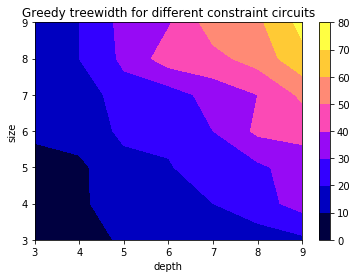

In [199]:
plt.title('Greedy treewidth for different constraint circuits')
levels = np.arange(0, max(tws)+10, 10, )

f = plot_pairwise(tws, params, 'depth', 'size', levels=levels, cmap=cm.gnuplot2)
plt.colorbar(f)

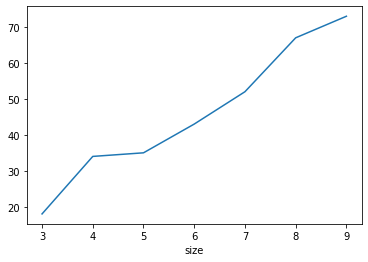

In [185]:
tw_fix_size = np.array(tws).reshape(len(params['depth']), -1)[:, 0] 

f = plot_pairwise_solo(tws, params, -1, 'size', 'depth')

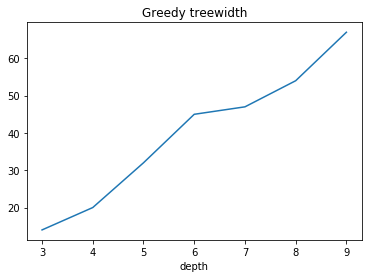

In [186]:
plt.title('Greedy treewidth')
f = plot_pairwise_solo(tws, params, 5, 'depth', 'size')

## 4-qubit gates

In [187]:
class CG(qtree.operators.Gate):
    _changes_qubits = (0,1,2,3)
    def gen_tensor(self):
        return np.eye(16, 16).reshape([2]*8)

class QtreeConstraintsCoupled(QtreeConstraintsComposer):
    
    def _couple_gate(self, ix):
        side_len = self.N + 1
        self.apply_gate_ix(CG, ix, ix+1, ix+side_len, ix+side_len+1)


In [188]:

def get_circ_4q(size, depth):
    composer = QtreeConstraintsCoupled(size, shifted_tiling_gen)
    qc = composer.get_circ(depth)
    return qc

In [189]:
qcs = [get_circ_4q(**args) for args in iter_params(params)]
tws_4q = [get_tw(qc) for qc in qcs]

2020-07-24 01:26:43.883 | INFO     | qensor.optimisation.TensorNet:get_line_graph:49 - Line graph nodes: 92, edges: 276
2020-07-24 01:26:43.930 | INFO     | qensor.optimisation.TensorNet:get_line_graph:49 - Line graph nodes: 112, edges: 320
2020-07-24 01:26:43.975 | INFO     | qensor.optimisation.TensorNet:get_line_graph:49 - Line graph nodes: 140, edges: 420
2020-07-24 01:26:44.068 | INFO     | qensor.optimisation.TensorNet:get_line_graph:49 - Line graph nodes: 160, edges: 464
2020-07-24 01:26:44.166 | INFO     | qensor.optimisation.TensorNet:get_line_graph:49 - Line graph nodes: 188, edges: 564
2020-07-24 01:26:44.288 | INFO     | qensor.optimisation.TensorNet:get_line_graph:49 - Line graph nodes: 208, edges: 608
2020-07-24 01:26:44.452 | INFO     | qensor.optimisation.TensorNet:get_line_graph:49 - Line graph nodes: 236, edges: 708
2020-07-24 01:26:44.630 | INFO     | qensor.optimisation.TensorNet:get_line_graph:49 - Line graph nodes: 144, edges: 433
2020-07-24 01:26:44.709 | INFO   

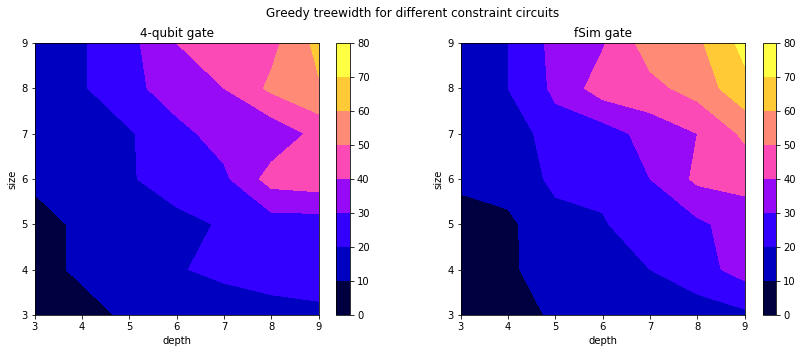

In [209]:

levels = np.arange(0, max(tws)+10, 10, )
fig, axs = plt.subplots(1,2,figsize=(14,5))
plt.suptitle('Greedy treewidth for different constraint circuits')
plt.sca(axs[0])
plt.title('4-qubit gate')
f = plot_pairwise(tws_4q, params, 'depth', 'size', levels=levels, cmap=cm.gnuplot2)
plt.colorbar(f)
plt.sca(axs[1])
plt.title('fSim gate')
f = plot_pairwise(tws, params, 'depth', 'size', levels=levels, cmap=cm.gnuplot2)
plt.colorbar(f)

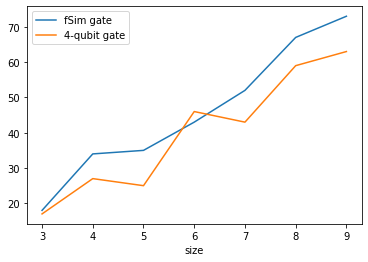

In [193]:

f = plot_pairwise_solo(tws, params, -1, 'size', 'depth', label='fSim gate')
f = plot_pairwise_solo(tws_4q, params, -1, 'size', 'depth', label='4-qubit gate')
plt.legend()

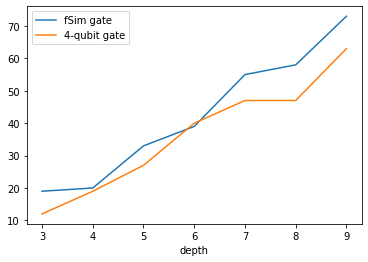

In [210]:
f = plot_pairwise_solo(tws, params, -1, 'depth', 'size', label='fSim gate')
f = plot_pairwise_solo(tws_4q, params, -1, 'depth', 'size', label='4-qubit gate')
plt.legend()